# Logistic Regression

**Author**: Stephanie Golob

**contact**: estefaniagolob@gmail.com

**Date**: July 4, 2022

**Previous Notebook**: 4 of 7 (Balancing Target Classes)

**Current Notebook**: 5 of 7

**Next Notebook**: 6 of 7 (Decision Tree)

---

In this notebook I will optimize Logistic Regression models using a pipeline and cross-validation and compare the results of the original data set and the balanced data sets.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Basic-Logistic-Regression-Model" data-toc-modified-id="Basic-Logistic-Regression-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Basic Logistic Regression Model</a></span></li><li><span><a href="#Model-Optimization-using-original-and-balanced-data-sets" data-toc-modified-id="Model-Optimization-using-original-and-balanced-data-sets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model Optimization using original and balanced data sets</a></span><ul class="toc-item"><li><span><a href="#Original-data" data-toc-modified-id="Original-data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Original data</a></span><ul class="toc-item"><li><span><a href="#Optimized-Logisitic-Regression-Model-with-Original-Data" data-toc-modified-id="Optimized-Logisitic-Regression-Model-with-Original-Data-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Optimized Logisitic Regression Model with Original Data</a></span></li></ul></li><li><span><a href="#Upsampled-Data" data-toc-modified-id="Upsampled-Data-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Upsampled Data</a></span></li><li><span><a href="#Downsampled-Data" data-toc-modified-id="Downsampled-Data-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Downsampled Data</a></span></li><li><span><a href="#SMOTE-Upsampled-Data" data-toc-modified-id="SMOTE-Upsampled-Data-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>SMOTE Upsampled Data</a></span></li></ul></li><li><span><a href="#Model-Summary-Table" data-toc-modified-id="Model-Summary-Table-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model Summary Table</a></span></li><li><span><a href="#Feature-Evaluation" data-toc-modified-id="Feature-Evaluation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Feature Evaluation</a></span></li><li><span><a href="#Next-Steps" data-toc-modified-id="Next-Steps-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Next Steps</a></span></li></ul></li></ul></div>

---

Import the required libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for scaling the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# cache memory for gridsearch
from tempfile import mkdtemp

# modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# save model outputs
import joblib

# model evaluation
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

Read in the train and validation sets.

In [2]:
X_train = pd.read_pickle("data/X_train.pkl")
y_train = pd.read_pickle("data/y_train.pkl")

X_validation = pd.read_pickle("data/X_validation.pkl")
y_validation = pd.read_pickle("data/y_validation.pkl")

## Basic Logistic Regression Model

Fit a basic Logistic Regression model with the original X_train and y_train data sets.

In [3]:
#instantiate the model
LR_model = LogisticRegression(random_state = 10, max_iter = 10000)

# fit the model
LR_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=10)

In [4]:
# 3. Score on the training data 
print("Training score: ", LR_model.score(X_train, y_train))

# 4. Score on the validation data
print("Validation score: ", LR_model.score(X_validation, y_validation))

Training score:  0.7470121225276424
Validation score:  0.747016798017082


The training score and validation score are very similar, the model is not overfitting to the training data. But in order to evaluate the predictions the model is making I am going to plot the confusion matrix. 

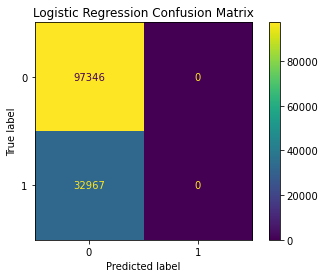

In [5]:
plot_confusion_matrix(LR_model, X_validation, y_validation)
plt.title("Logistic Regression Confusion Matrix");

The basic Logistic Regression model is only predicting class 0 (On-time flights).

Get the predicted y values by using `predict` on the X_validation data set.

In [6]:
y_predictions = LR_model.predict(X_validation)

Use the predictions and the y_validation set to get the precision, recall and f1-scores for the model.

In [7]:
report_LR_basic = classification_report(y_validation, y_predictions)
print(report_LR_basic)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     97346
           1       0.00      0.00      0.00     32967

    accuracy                           0.75    130313
   macro avg       0.37      0.50      0.43    130313
weighted avg       0.56      0.75      0.64    130313



The precision and recall scores are very high for class 0, and 0 for class 1, as is expected from the confusion matrix.

---

## Model Optimization using original and balanced data sets

I'm going to create a pipeline to optimize the Logistic Regression models using the original and balanced data sets. I will then make predictions and compare the model outputs using the confusion matrices and precision, recall and f1-scores.

- First - original data
- Second - Upsampled data
- Third - Downsampled data
- Fourth - SMOTE Upsampled data

### Original data

In [8]:
# create a memory cache
cachedir = mkdtemp()

# create a list of tuples to store the functions that will be completed in the pipeline
# normalize the data using a StandardScaler
# instantiate the Logistic Regression model
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

# intialize the pipeline, input estimators as the steps for the pipeline to take
pipe = Pipeline(estimators)

# set the parameters that you want GridSearchCV to iterate through
# I want the pipeline to test whether a StandardScaler or none is optimal
# then it will fit the LR model, and loop through the range of C values I have input
parameters = [
            {'model': [LogisticRegression()], 
             'normalise': [StandardScaler(), None],
             'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

# use GridSearchCV, input the pipeline, the parameters to test and the number of times it should cross-validate
# cross-validation creates a different number of splits of the data
# we don't need to split the data again because cross-validation will split the data 5 times into different variations
# of train and validation
orig_grid = GridSearchCV(pipe, parameters, cv = 5, verbose = 2, scoring = 'roc_auc')

# fit the grid on the original X_train and y_train data
orig_fitgrid = orig_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.5s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.5s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.5s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.5s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.5s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s

Save the grid output using `dump` from the joblib library.

In [9]:
# select the output to save and give it a name
# saves as a .pkl file

joblib.dump(orig_fitgrid, 'Models/LR_orig_grid.pkl')

['Models/LR_orig_grid.pkl']

The grid has fit on X_train and y_train. From the gridsearch outputs we can see that the run-time using StandardScaler is faster than without. 

The results of the gridsearch can be saved in a dataframe using `cv_results` to get the grid outputs.

In [10]:
orig_df = pd.DataFrame(orig_fitgrid.cv_results_)
orig_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_normalise,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.420421,0.004346,0.114254,0.001650,LogisticRegression(C=0.001),0.001,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.676485,0.679628,0.680986,0.677596,0.678534,0.678646,0.001564,1
1,0.614127,0.002801,0.110755,0.000937,LogisticRegression(C=0.001),0.001,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.480881,0.482750,0.479898,0.484107,0.483211,0.482169,0.001549,8
2,0.414687,0.003932,0.112847,0.000374,LogisticRegression(C=0.001),0.01,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.676504,0.679623,0.680975,0.677571,0.678531,0.678641,0.001558,2
3,0.608759,0.008804,0.110549,0.001095,LogisticRegression(C=0.001),0.01,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.480881,0.482750,0.479898,0.484107,0.483211,0.482169,0.001549,7
4,0.415497,0.005495,0.112234,0.001268,LogisticRegression(C=0.001),0.1,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.676506,0.679623,0.680973,0.677569,0.678530,0.678640,0.001557,3
5,0.620683,0.005885,0.110915,0.001128,LogisticRegression(C=0.001),0.1,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.480881,0.482750,0.479898,0.484107,0.483211,0.482169,0.001549,8
6,0.406610,0.003782,0.112594,0.000630,LogisticRegression(C=0.001),1,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.676506,0.679623,0.680973,0.677569,0.678530,0.678640,0.001557,6
7,0.611976,0.006529,0.110589,0.000785,LogisticRegression(C=0.001),1,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.480881,0.482750,0.479898,0.484107,0.483211,0.482169,0.001549,8
8,0.411150,0.004798,0.111797,0.000820,LogisticRegression(C=0.001),10,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.676506,0.679623,0.680973,0.677569,0.678530,0.678640,0.001557,4
9,0.614943,0.009617,0.110326,0.000756,LogisticRegression(C=0.001),10,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.480881,0.482750,0.479898,0.484107,0.483211,0.482169,0.001549,8


Use `best_estimator_` to get the optimal hyperparameters for this data.

In [11]:
orig_fitgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=0.001))])

The best model was normalized using StandardScaler and had a C value of 0.001. To get the results from this model I need to re-fit a LR model with the parameters selected by gridsearch. First I will scale X_train and transform the X_train and X_validation data sets.

In [12]:
# instantiate the scaler
scaler = StandardScaler()

#fit the scaler on X_train
scaler.fit(X_train)

# transform X_train and X_validation
X_train_s = scaler.transform(X_train)
X_validation_s = scaler.transform(X_validation)

#### Optimized Logisitic Regression Model with Original Data

In [13]:
#Model with original scaled data

#instantiate the model
LR_model_orig = LogisticRegression(random_state = 10, max_iter = 10000, C = 0.001)

# fit the model
LR_model_orig.fit(X_train_s, y_train)

LogisticRegression(C=0.001, max_iter=10000, random_state=10)

Plot the confusion matrix using the scaled X_validation set, the y_validation set and the Logistic Regression model outputs.

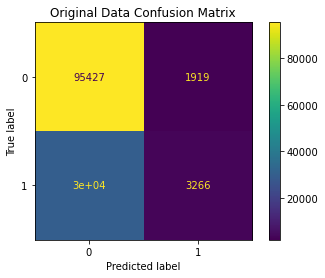

In [14]:
plot_confusion_matrix(LR_model_orig, X_validation_s, y_validation)
plt.title("Original Data Confusion Matrix");

The model improves at predicting class 1 using scaled data, but it is still predicting Class 0 the majority of the time.

Make predictions using the scaled X_validation_s set.

In [15]:
y_predictions_orig = LR_model_orig.predict(X_validation_s)

Use the predictions and the y_validation data set to create a classification report.

In [16]:
report_orig = classification_report(y_validation, y_predictions_orig)
print(report_orig)

              precision    recall  f1-score   support

           0       0.76      0.98      0.86     97346
           1       0.63      0.10      0.17     32967

    accuracy                           0.76    130313
   macro avg       0.70      0.54      0.51    130313
weighted avg       0.73      0.76      0.68    130313



The optimized Logistic Regression model using the original data has improved the precision and the recall for class 1, but as seen above in the Confusion Matrix it's still doing a poor job of predicting Class 1.

Tuning the hyperparameters for the basic Logistic Regression model has already improved the precision, recall and f1-score for Class 1, as well as the AUC score. I will now repeat the same steps for the upsampled, downsampled and SMOTE upsampled data. 

---

###  Upsampled Data

Read in the upsampled X_train and y_train data.

In [17]:
X_train_up = pd.read_pickle("data/X_train_over.pkl")
y_train_up = pd.read_pickle("data/y_train_over.pkl")

In [18]:
# store estimators
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

# instantiate pipeline
pipe = Pipeline(estimators)

# create parameters for gridsearch
parameters = [
            {'model': [LogisticRegression()], 
             'normalise': [StandardScaler(), None],
             'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

#instantiate gridsearch
up_grid = GridSearchCV(pipe, parameters, cv = 5, verbose = 2, scoring = 'roc_auc')

# fit the grid on the upsampled X_train and y_train data
up_fitgrid = up_grid.fit(X_train_up, y_train_up)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.9s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.8s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s

Save the grid output using `dump` from the joblib library.

In [19]:
# select the output to save and give it a name
# saves as a .pkl file

joblib.dump(up_fitgrid, 'Models/LR_up_grid.pkl')

['Models/LR_up_grid.pkl']

The grid has fit on X_train_up and y_train_up. 

The results of the gridsearch can be saved in a dataframe using `cv_results` to get the grid outputs.

In [20]:
up_df = pd.DataFrame(up_fitgrid.cv_results_)
up_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_normalise,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.672193,0.015622,0.172965,0.002826,LogisticRegression(C=0.001),0.001,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.678358,0.680919,0.679750,0.678769,0.678121,0.679183,0.001031,1
1,0.572288,0.009363,0.168598,0.001329,LogisticRegression(C=0.001),0.001,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.541776,0.541274,0.541293,0.545808,0.540755,0.542181,0.001842,7
2,0.648110,0.002560,0.171059,0.000917,LogisticRegression(C=0.001),0.01,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.678356,0.680922,0.679766,0.678753,0.678120,0.679183,0.001036,2
3,0.553683,0.005940,0.168224,0.000178,LogisticRegression(C=0.001),0.01,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.541776,0.541274,0.541293,0.545808,0.540755,0.542181,0.001842,7
4,0.650445,0.011650,0.172026,0.001364,LogisticRegression(C=0.001),0.1,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.678355,0.680923,0.679767,0.678751,0.678120,0.679183,0.001036,5
5,0.551658,0.003733,0.168917,0.001219,LogisticRegression(C=0.001),0.1,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.541776,0.541274,0.541293,0.545808,0.540755,0.542181,0.001842,7
6,0.645661,0.003176,0.170767,0.001421,LogisticRegression(C=0.001),1,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.678355,0.680923,0.679767,0.678751,0.678120,0.679183,0.001036,6
7,0.554342,0.003853,0.167870,0.001882,LogisticRegression(C=0.001),1,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.541776,0.541274,0.541293,0.545808,0.540755,0.542181,0.001842,7
8,0.647865,0.003517,0.170436,0.001790,LogisticRegression(C=0.001),10,StandardScaler(),"{'model': LogisticRegression(C=0.001), 'model_...",0.678355,0.680923,0.679767,0.678751,0.678120,0.679183,0.001036,4
9,0.553871,0.001813,0.168064,0.000814,LogisticRegression(C=0.001),10,None,"{'model': LogisticRegression(C=0.001), 'model_...",0.541776,0.541274,0.541293,0.545808,0.540755,0.542181,0.001842,7


Use `best_estimator_` to get the optimal hyperparameters for this data.

In [21]:
up_fitgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=0.001))])

The best model is normalized using Standard Scaler and has a C value of 0.001. Re-run the Logistic Regression model using Standard Scaler and C=0.001 to produce the confusion matrix and the precision, recall and f1-scores.

In [22]:
# Model with upsampled scaled data

# Scale the upsampled data
scaler = StandardScaler()

# fit on X_train_up
scaler.fit(X_train_up)

# transform X_train_up and X_validation
X_train_up_s = scaler.transform(X_train_up)
X_validation_s = scaler.transform(X_validation)

#instantiate the model
LR_model_up = LogisticRegression(random_state = 10, max_iter = 10000, C = 0.001)

# fit the model
LR_model_up.fit(X_train_up_s, y_train_up)

LogisticRegression(C=0.001, max_iter=10000, random_state=10)

Plot the confusion matrix and the precision, recall and f1-scores to see how the model is predicting each class.

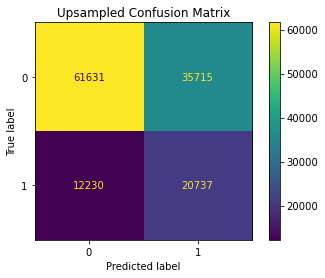

In [23]:
plot_confusion_matrix(LR_model_up, X_validation_s, y_validation)
plt.title("Upsampled Confusion Matrix");

The model improves at predicting class 1 using scaled upsampled data.

Make predictions using the scaled X_validation_s data.

In [24]:
y_predictions_up = LR_model_up.predict(X_validation_s)

Create the classification report.

In [25]:
report_up = classification_report(y_validation, y_predictions_up)
print(report_up)

              precision    recall  f1-score   support

           0       0.83      0.63      0.72     97346
           1       0.37      0.63      0.46     32967

    accuracy                           0.63    130313
   macro avg       0.60      0.63      0.59    130313
weighted avg       0.72      0.63      0.66    130313



Precision and recall scores have improved for class 1. The recall scores for both classes are the same, however the f1-scores for each class reflect the lower precision score for Class 1 as compared to Class 0. 

---

### Downsampled Data

Read in the downsampled X_train and y_train data.

In [26]:
X_train_down = pd.read_pickle("data/X_train_under.pkl")
y_train_down = pd.read_pickle("data/y_train_under.pkl")

In [27]:
# store estimators
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

# instantiate pipeline
pipe = Pipeline(estimators)

# create parameters for gridsearch
parameters = [
            {'model': [LogisticRegression()], 
             'normalise': [StandardScaler(), None],
             'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

#instantiate gridsearch
down_grid = GridSearchCV(pipe, parameters, cv = 5, verbose = 2, scoring = 'roc_auc')

# fit the grid on the upsampled X_train and y_train data
down_fitgrid = down_grid.fit(X_train_down, y_train_down)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.2s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.2s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.2s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.2s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.2s

Save the grid output using `dump` from the joblib library.

In [28]:
# select the output to save and give it a name
# saves as a .pkl file

joblib.dump(down_fitgrid, 'Models/LR_down_grid.pkl')

['Models/LR_down_grid.pkl']

The grid has fit on X_train_down and y_train_down. 

The results of the gridsearch can be saved in a dataframe using `cv_results` to get the grid outputs.

In [29]:
down_df = pd.DataFrame(down_fitgrid.cv_results_)
down_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_normalise,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.216756,0.003593,0.052445,0.001358,LogisticRegression(C=0.01),0.001,StandardScaler(),"{'model': LogisticRegression(C=0.01), 'model__...",0.676298,0.675153,0.679197,0.680878,0.682205,0.678746,0.002669,2
1,0.188871,0.001890,0.051577,0.000281,LogisticRegression(C=0.01),0.001,None,"{'model': LogisticRegression(C=0.01), 'model__...",0.541648,0.542883,0.539820,0.541491,0.544637,0.542096,0.001601,7
2,0.215715,0.006426,0.051941,0.000242,LogisticRegression(C=0.01),0.01,StandardScaler(),"{'model': LogisticRegression(C=0.01), 'model__...",0.676299,0.675169,0.679167,0.680879,0.682219,0.678747,0.002667,1
3,0.182076,0.003286,0.051939,0.000308,LogisticRegression(C=0.01),0.01,None,"{'model': LogisticRegression(C=0.01), 'model__...",0.541648,0.542883,0.539820,0.541491,0.544637,0.542096,0.001601,7
4,0.212665,0.001473,0.052164,0.000511,LogisticRegression(C=0.01),0.1,StandardScaler(),"{'model': LogisticRegression(C=0.01), 'model__...",0.676299,0.675171,0.679162,0.680878,0.682219,0.678746,0.002666,3
5,0.183063,0.001937,0.051968,0.000422,LogisticRegression(C=0.01),0.1,None,"{'model': LogisticRegression(C=0.01), 'model__...",0.541648,0.542883,0.539820,0.541491,0.544637,0.542096,0.001601,7
6,0.211963,0.000565,0.051728,0.000266,LogisticRegression(C=0.01),1,StandardScaler(),"{'model': LogisticRegression(C=0.01), 'model__...",0.676299,0.675171,0.679162,0.680878,0.682218,0.678746,0.002666,4
7,0.179450,0.003753,0.051544,0.000154,LogisticRegression(C=0.01),1,None,"{'model': LogisticRegression(C=0.01), 'model__...",0.541648,0.542883,0.539820,0.541491,0.544637,0.542096,0.001601,7
8,0.210384,0.002759,0.051757,0.000125,LogisticRegression(C=0.01),10,StandardScaler(),"{'model': LogisticRegression(C=0.01), 'model__...",0.676299,0.675171,0.679162,0.680878,0.682219,0.678746,0.002666,5
9,0.183231,0.001408,0.051738,0.000386,LogisticRegression(C=0.01),10,None,"{'model': LogisticRegression(C=0.01), 'model__...",0.541648,0.542883,0.539820,0.541491,0.544637,0.542096,0.001601,7


In [30]:
down_fitgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=0.01))])

The best model is normalized using Standard Scaler and has a C value of 0.01. Re-run the Logistic Regression model using Standard Scaler and C=0.01 to produce the confusion matrix and the precision, recall and f1-scores.

In [31]:
#Model with downsampled scaled data

# Scale the downsampled data
# instantiate the scaler
scaler = StandardScaler()

# fit the scaler on X_train_down data
scaler.fit(X_train_down)

# transform X_train_down and X_validation
X_train_down_s = scaler.transform(X_train_down)
X_validation_s = scaler.transform(X_validation)

#instantiate the model
LR_model_down = LogisticRegression(random_state = 10, max_iter = 10000, C = 0.01)

# fit the model on the downsampled X_train_down and y_train_down data sets
LR_model_down.fit(X_train_down_s, y_train_down)

LogisticRegression(C=0.01, max_iter=10000, random_state=10)

Compare the results of the confusion matrix and classification report.

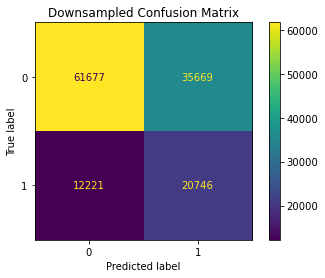

In [32]:
plot_confusion_matrix(LR_model_down, X_validation_s, y_validation)
plt.title("Downsampled Confusion Matrix");

The model improves at predicting class 1 using scaled downsampled data.

In [33]:
y_predictions_down = LR_model_down.predict(X_validation_s)

In [34]:
report_down = classification_report(y_validation, y_predictions_down)
print(report_down)

              precision    recall  f1-score   support

           0       0.83      0.63      0.72     97346
           1       0.37      0.63      0.46     32967

    accuracy                           0.63    130313
   macro avg       0.60      0.63      0.59    130313
weighted avg       0.72      0.63      0.66    130313



The scores for the downsampled data are exactly the same as for the upsampled data, showing that both balancing techniques have improved the model's performance. 

---

### SMOTE Upsampled Data

Read in the SMOTE upsampled X_train and y_train data.

In [35]:
X_train_smote = pd.read_pickle("data/X_train_smote.pkl")
y_train_smote = pd.read_pickle("data/y_train_smote.pkl")

In [36]:
# store estimators
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

# instantiate pipeline
pipe = Pipeline(estimators)

# create parameters for gridsearch
parameters = [
            {'model': [LogisticRegression()], 
             'normalise': [StandardScaler(), None],
             'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

#instantiate gridsearch
smote_grid = GridSearchCV(pipe, parameters, cv = 5, verbose = 2, scoring = 'roc_auc')

# fit the grid on the upsampled X_train and y_train data
smote_fitgrid = smote_grid.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.9s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.9s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.9s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.9s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=StandardScaler(); total time=   0.9s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.8s
[CV] END model=LogisticRegression(), model__C=0.001, normalise=None; total time=   0.7s

Save the grid output using `dump` from the joblib library.

In [37]:
# select the output to save and give it a name
# saves as a .pkl file

joblib.dump(smote_fitgrid, 'Models/LR_smote_grid.pkl')

['Models/LR_smote_grid.pkl']

The grid has fit on X_train_smote and y_train_smote. 

The results of the gridsearch can be saved in a dataframe using `cv_results` to get the grid outputs.

In [38]:
smote_df = pd.DataFrame(smote_fitgrid.cv_results_)
smote_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_normalise,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.717077,0.017837,0.170095,0.001170,LogisticRegression(C=10),0.001,StandardScaler(),"{'model': LogisticRegression(C=10), 'model__C'...",0.653871,0.705576,0.802140,0.801355,0.801821,0.752953,0.061987,6
1,0.575941,0.005469,0.168525,0.001508,LogisticRegression(C=10),0.001,None,"{'model': LogisticRegression(C=10), 'model__C'...",0.541774,0.543005,0.539864,0.543086,0.541228,0.541791,0.001199,7
2,0.751185,0.004808,0.171837,0.000961,LogisticRegression(C=10),0.01,StandardScaler(),"{'model': LogisticRegression(C=10), 'model__C'...",0.654322,0.705823,0.802047,0.801129,0.801680,0.753000,0.061733,5
3,0.560430,0.005058,0.168891,0.001227,LogisticRegression(C=10),0.01,None,"{'model': LogisticRegression(C=10), 'model__C'...",0.541774,0.543005,0.539864,0.543086,0.541228,0.541791,0.001199,7
4,0.796362,0.013796,0.170324,0.001860,LogisticRegression(C=10),0.1,StandardScaler(),"{'model': LogisticRegression(C=10), 'model__C'...",0.654387,0.705859,0.802029,0.801089,0.801654,0.753004,0.061693,4
5,0.556307,0.006210,0.169280,0.001966,LogisticRegression(C=10),0.1,None,"{'model': LogisticRegression(C=10), 'model__C'...",0.541774,0.543005,0.539864,0.543086,0.541228,0.541791,0.001199,7
6,0.836543,0.020413,0.168436,0.001121,LogisticRegression(C=10),1,StandardScaler(),"{'model': LogisticRegression(C=10), 'model__C'...",0.654396,0.705863,0.802027,0.801083,0.801650,0.753004,0.061688,3
7,0.558193,0.007780,0.168127,0.000870,LogisticRegression(C=10),1,None,"{'model': LogisticRegression(C=10), 'model__C'...",0.541774,0.543005,0.539864,0.543086,0.541228,0.541791,0.001199,7
8,0.879160,0.018663,0.170657,0.001715,LogisticRegression(C=10),10,StandardScaler(),"{'model': LogisticRegression(C=10), 'model__C'...",0.654397,0.705864,0.802026,0.801083,0.801650,0.753004,0.061687,1
9,0.558733,0.003383,0.167809,0.002349,LogisticRegression(C=10),10,None,"{'model': LogisticRegression(C=10), 'model__C'...",0.541774,0.543005,0.539864,0.543086,0.541228,0.541791,0.001199,7


In [39]:
smote_fitgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=10))])

The best model is normalized using Standard Scaler and has a C value of 10. Re-run the Logistic Regression model using Standard Scaler and C=10 to produce the confusion matrix and the precision, recall and f1-scores.

In [40]:
#Model with SMOTE upsampled scaled data

# Scale the SMOTE upsampled data
#instantiate the scaler
scaler = StandardScaler()

# fit the scaler on the smote data
scaler.fit(X_train_smote)

# transform X_train_smote and X_validation
X_train_smote_s = scaler.transform(X_train_smote)
X_validation_s = scaler.transform(X_validation)


#instantiate the model
LR_model_smote = LogisticRegression(random_state = 10, max_iter = 10000, C = 10)

# fit the model on the scaled X_train_smote_s and y_train_smote_s
LR_model_smote.fit(X_train_smote_s, y_train_smote)

LogisticRegression(C=10, max_iter=10000, random_state=10)

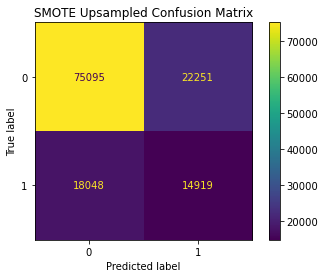

In [41]:
plot_confusion_matrix(LR_model_smote, X_validation_s, y_validation)
plt.title("SMOTE Upsampled Confusion Matrix");

The model improves at predicting class 1 with the SMOTE upsampled data, but it seems to be predicting class 0 more than class 1. 

Calculate the model predictions using the scaled X_validation data.

In [42]:
y_predictions_smote = LR_model_smote.predict(X_validation_s)

Create a classification report.

In [43]:
report_smote = classification_report(y_validation, y_predictions_smote)
print(report_smote)

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     97346
           1       0.40      0.45      0.43     32967

    accuracy                           0.69    130313
   macro avg       0.60      0.61      0.61    130313
weighted avg       0.70      0.69      0.70    130313



Precision and recall scores have decreased for class 1 using SMOTE upsampled data, as compared to the upsampled/downsampled data.  

---

## Model Summary Table

The results of the classification reports of each model are summarized in the table below.

| Data        | Class   | Precision | Recall | F1   |
|-------------|---------|-----------|--------|------|
| Original    |         |           |        |      |
|             | Class 0 | 0.76      | 0.98   | 0.86 |
|             | Class 1 | 0.63      | 0.10   | 0.17 |
| Upsampled   |         |           |        |      |
|             | Class 0 | 0.83      | 0.63   | 0.72 |
|             | Class 1 | 0.37      | 0.63   | 0.46 |
| Downsampled |         |           |        |      |
|             | Class 0 | 0.83      | 0.63   | 0.72 |
|             | Class 1 | 0.37      | 0.63   | 0.46 |
| SMOTE       |         |           |        |      |
|             | Class 0 | 0.81      | 0.77   | 0.79 |
|             | Class 1 | 0.40      | 0.45   | 0.43 | 

---

## Feature Evaluation

The best results from the optimized models were from the upsampled and downsampled data sets. Since I got the same f1-scores for each model, I will evaluate the features using the downsampled data.

Get the coefficients for each feature from the downsampled model using `coef`.

In [44]:
LR_down_coefs = LR_model_down.coef_

Create a dataframe with the feature names and the coefficient values.

In [45]:
# Put the feature names and their coefficient values into a data frame
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefs': LR_model_down.coef_[0]})

# set the index as the variable name for plotting
coef_df = coef_df.set_index("Feature")
coef_df

,Coefs
Feature,
Year,0.330665
Quarter,0.048220
DayofMonth,-0.018848
DayofWeek,0.081982
CRSDepTime,0.242304
CRSElapsedTime,0.190570
PRCP,0.220298
TMIN,0.079663
WDF2,-0.003309


Plot out the values of each coefficient to see the feature importance for each class.

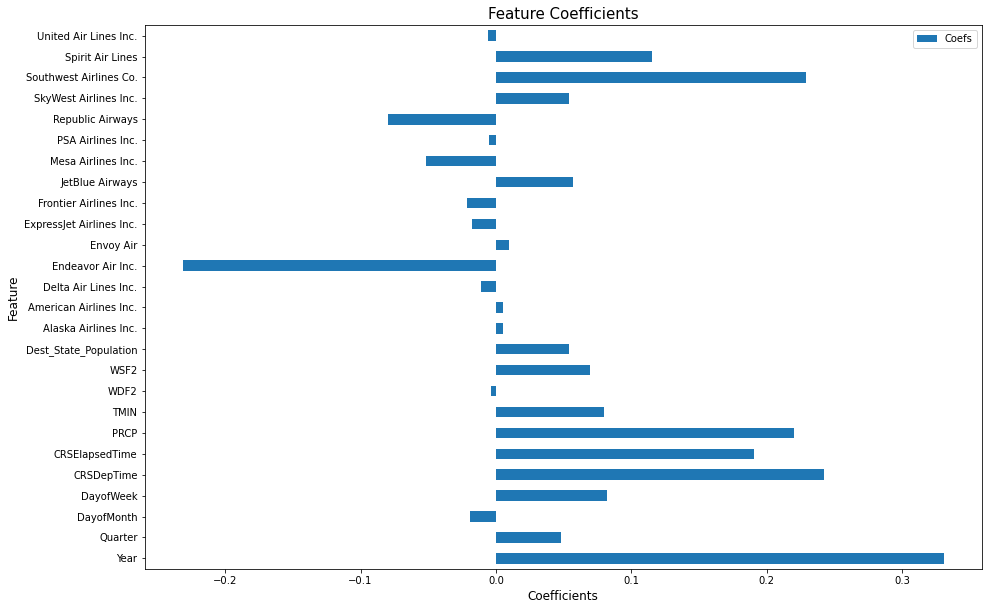

In [46]:
coef_df.plot(kind = "barh", figsize = (15,10))

plt.title("Feature Coefficients", fontsize = 15)
plt.xlabel("Coefficients", fontsize = 12)
plt.ylabel("Feature", fontsize = 12)

plt.show()

Observations:

- The year coefficient is the largest positive coefficient for Class 1 meaning that flights in 2021 are more likely to be delayed which was shown in the EDA section. In 2020 there was a decrease in the number of flights operating per day and we also know that less people were flying so there were less delays as a result. When travel returned to near pre-pandemic levels there were more likely to be delays since there were more travelers and a shortage of staff for all of these flights;
- Departure Time (CRSDepTime) has a positive coefficient for Class 1, meaning that flights that depart later in the day are more likely to be delayed, this makes sense since we expect more delays later in the day since there are likely to be knock-on effects which could cause delays later in the day;
- Elapsed Time (CRSElapsedTime) also has a positive coefficient for Class 1, meaning that flights that are longer distances are more likely to be delayed;
- Precipitation (PRCP) increases the likelihood of delays, and where precipitation is lower the flights are more likely to leave on time;
- Southwest Airlines have a positive coefficient meaning that flying with this airline is likely to increase the chances of a delay, additionally Endeavor Air Inc. has a negative coefficient meaning that flying with this airline is more likely to result in an on-time departure.

Calculate the odds ratio for each class by indexing the coefficients and using `np.exp` to calculate the exponential function of each coefficient. Start with class 1.

In [47]:
odds = np.exp(LR_model_down.coef_)

In [48]:
odds

array([[1.39189394, 1.04940146, 0.98132829, 1.08543643, 1.2741815 ,
        1.20993868, 1.24644814, 1.08292243, 0.99669664, 1.07228559,
        1.0553264 , 1.00559343, 1.00523332, 0.9890122 , 0.79342002,
        1.009506  , 0.98258281, 0.97875363, 1.05866425, 0.9494191 ,
        0.99523321, 0.92349683, 1.05541396, 1.25787108, 1.12258921,
        0.99440504]])

Plot the odds ratio for each feature by class.

In [49]:
odds_df.plot(kind = "barh", stacked = False, figsize = (15,10))
plt.axvline(x = 1, c = "gray", linestyle="--")

plt.title("Odds Ratio")
plt.xlabel("Odds")
plt.ylabel("Feature Name")

plt.show()

NameError: name 'odds_df' is not defined

Observations:

- The odds ratio shows similar patterns to the coefficients, such that Year, Elapsed Time, Departure Time, Precipitation and Southwest Airlines are more likely to increase the odds of a flight being delayed.

---

## Next Steps

I'm going to use Decision Trees in the next notebook (Notebook 6) to test if the precision and recall scores improve with another model.

---